In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating

In [2]:
# 1. IMPORTAR LIBRERÍAS NECESARIAS
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 2. REORGANIZAR VALIDATION FOLDER (val/)
val_dir = '/content/tiny-imagenet-200/val'
val_img_dir = os.path.join(val_dir, 'images')
val_annotations = os.path.join(val_dir, 'val_annotations.txt')

# Crear carpetas por clase y mover imágenes
with open(val_annotations, 'r') as f:
    for line in f.readlines():
        parts = line.strip().split('\t')
        img_file = parts[0]
        class_name = parts[1]
        class_dir = os.path.join(val_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        shutil.move(os.path.join(val_img_dir, img_file), os.path.join(class_dir, img_file))

# Limpiar
shutil.rmtree(val_img_dir)
os.remove(val_annotations)

# 3. CONFIGURACIÓN DE DATA AUGMENTATION
train_dir = '/content/tiny-imagenet-200/train'
val_dir = '/content/tiny-imagenet-200/val'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical'
)

num_classes = train_generator.num_classes

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [3]:
# 4. DEFINIR MODELO USANDO MobileNetV2 PREENTRENADO
base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Congelar pesos

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

<ipython-input-3-3a9f4205f183>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        51,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,637,320 (10.06 MB)

 Trainable params: 379,336 (1.45 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
# 5. ENTRENAMIENTO
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 472s 298ms/step - accuracy: 0.0558 - loss: 4.9993 - val_accuracy: 0.2238 - val_loss: 3.6156
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 457s 292ms/step - accuracy: 0.2176 - loss: 3.6714 - val_accuracy: 0.2767 - val_loss: 3.2759
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 447s 286ms/step - accuracy: 0.2603 - loss: 3.3865 - val_accuracy: 0.2960 - val_loss: 3.1385
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 443s 283ms/step - accuracy: 0.2820 - loss: 3.2487 - val_accuracy: 0.3102 - val_loss: 3.0668
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 506s 286ms/step - accuracy: 0.2984 - loss: 3.1696 - val_accuracy: 0.3180 - val_loss: 3.0210
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 454s 290ms/step - accuracy: 0.3068 - loss: 3.1048 - val_accuracy: 0.3237 - val_loss: 2.9957
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 505s 292ms/step - accuracy: 0.3133 - loss: 3.0675 - val_accuracy: 0.3343 - val_loss: 2.9556
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 446s 285ms/step - ac

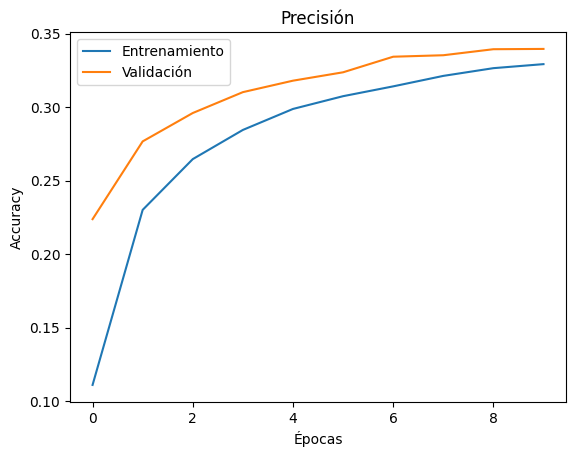

In [5]:
# 6. VISUALIZAR
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


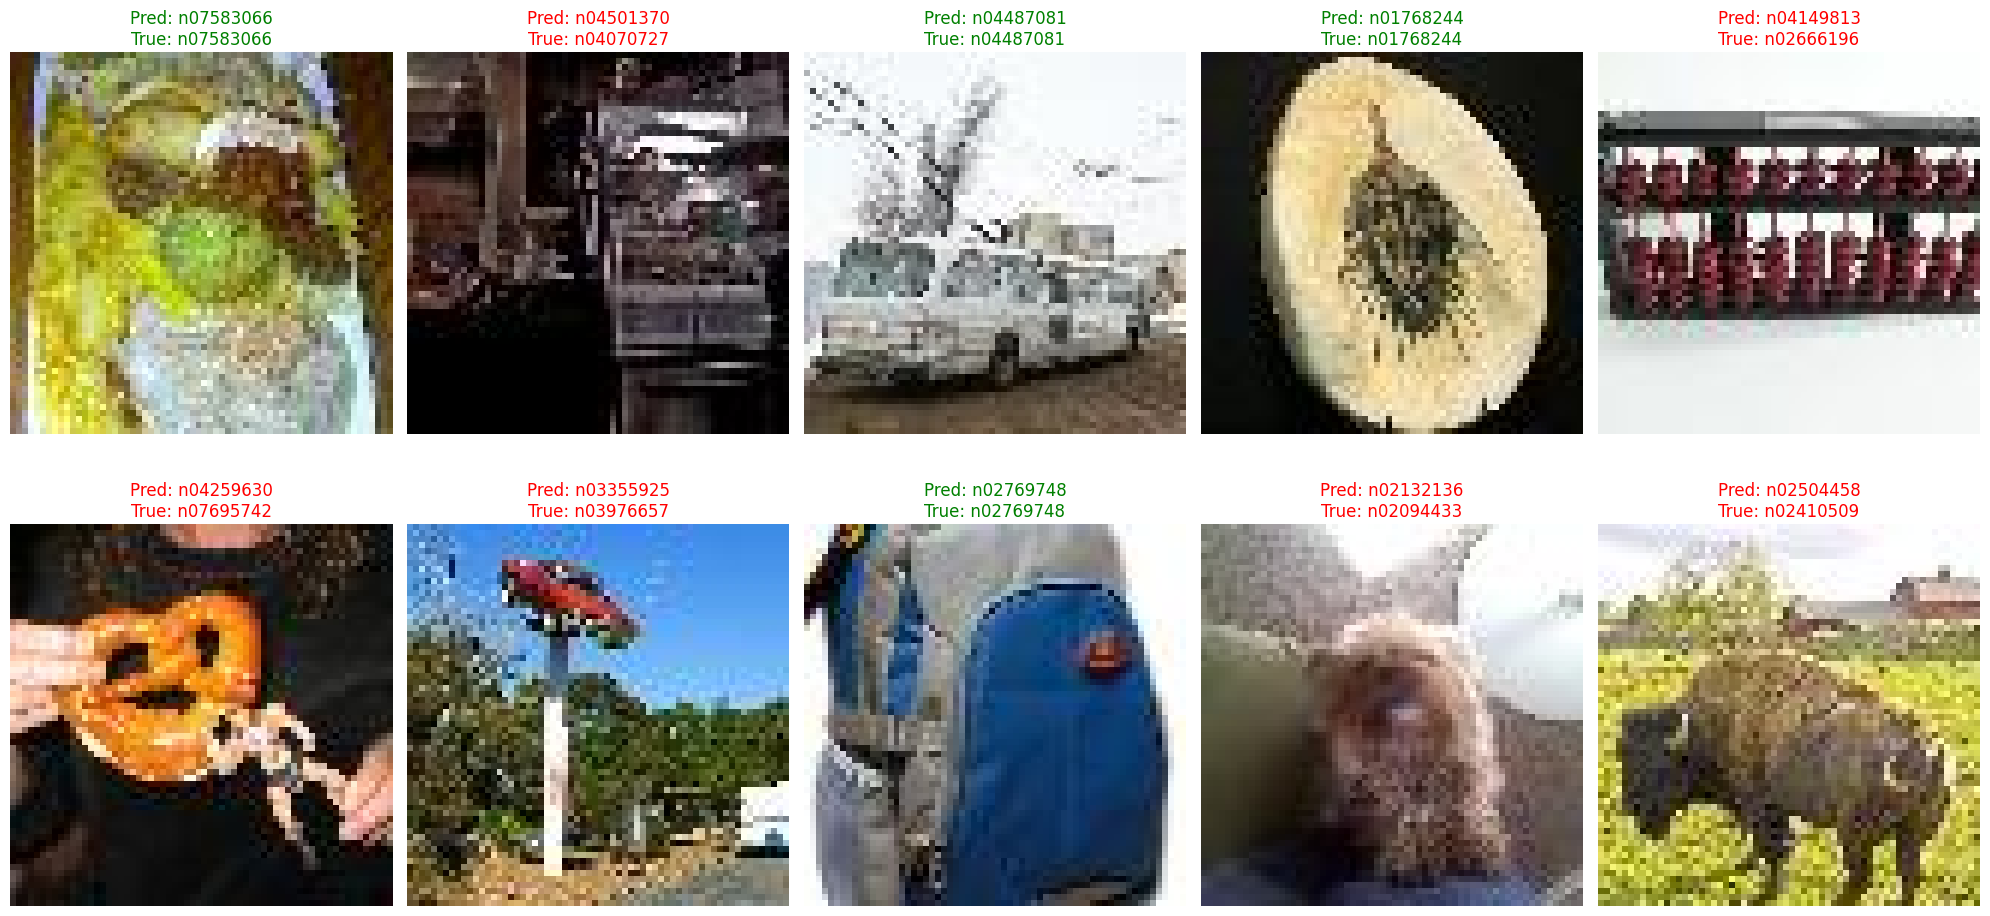

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Clases (200 clases de Tiny ImageNet, deben estar en el mismo orden que val_generator.class_indices)
class_names = list(val_generator.class_indices.keys())

# Obtener un lote de imágenes de validación
images, labels = next(val_generator)

# Hacer predicciones
predictions = model.predict(images)

# Mostrar las primeras 10 imágenes con etiquetas reales y predichas
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    true_label = class_names[np.argmax(labels[i])]
    predicted_label = class_names[np.argmax(predictions[i])]
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f'Pred: {predicted_label}\nTrue: {true_label}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()


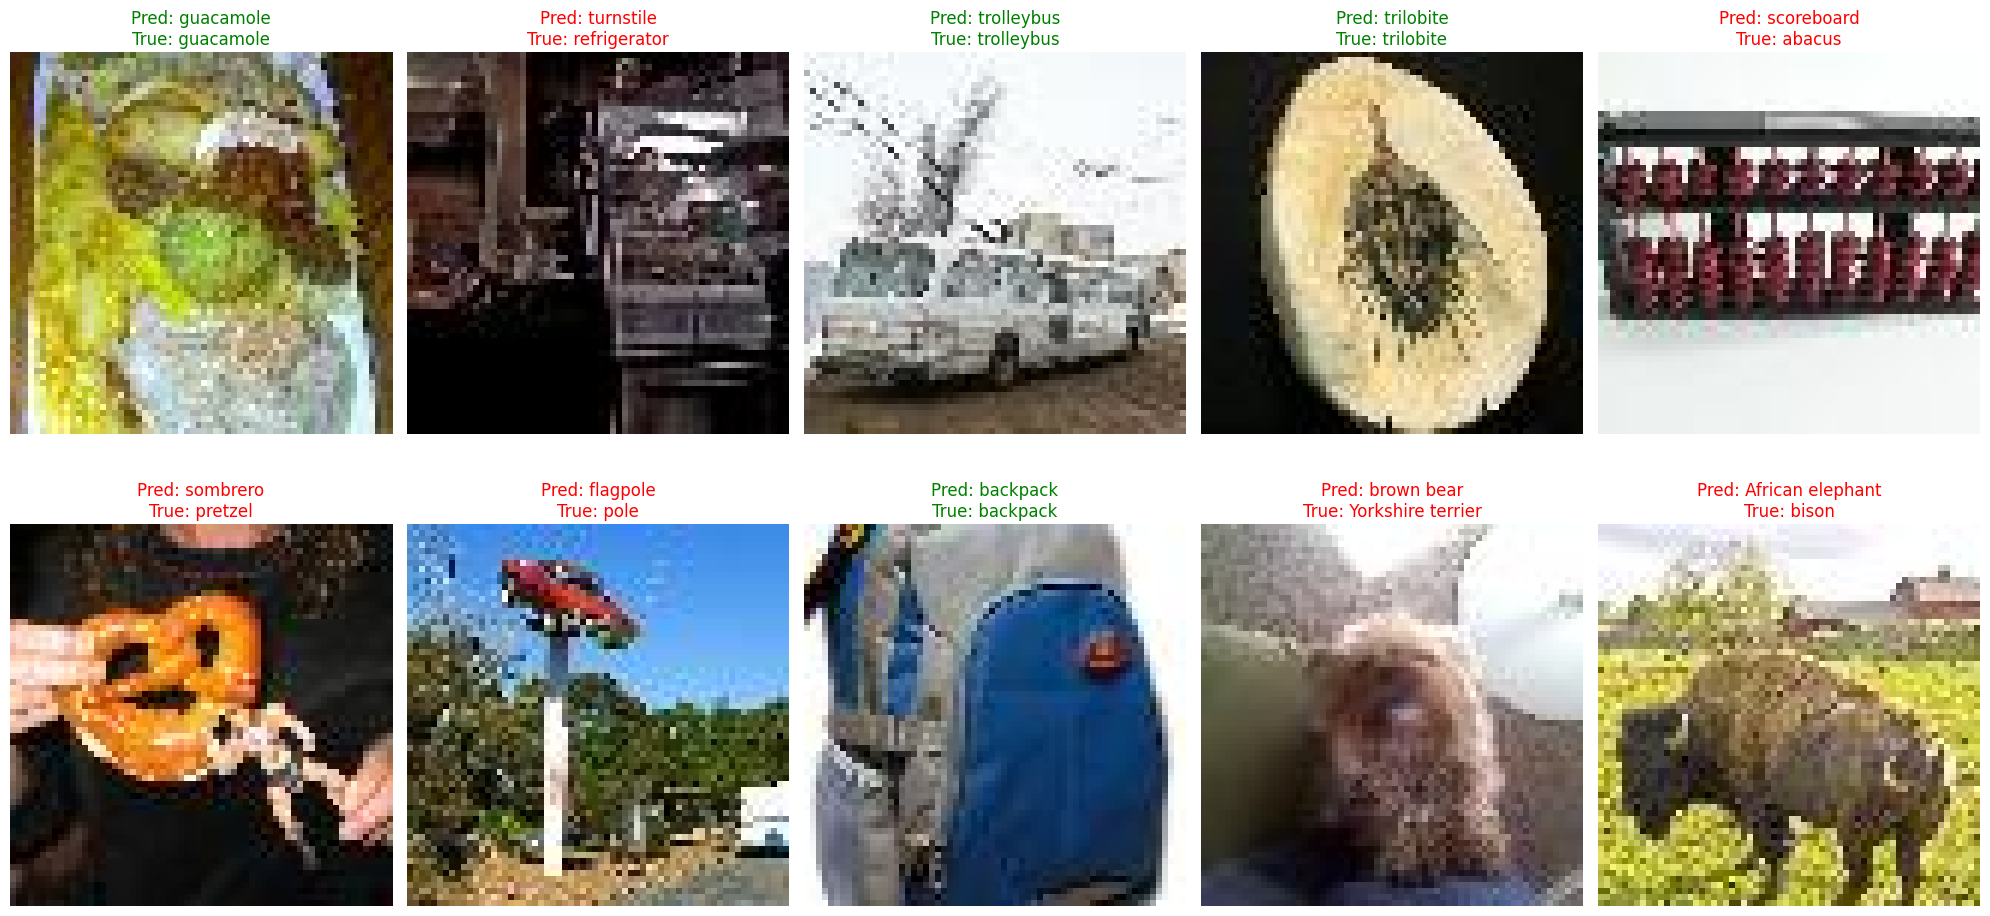

In [9]:
# 1. Cargar mapeo de etiquetas
id_to_label = {}
with open('tiny-imagenet-200/words.txt', 'r') as f:
    for line in f.readlines():
        parts = line.strip().split('\t')
        if len(parts) == 2:
            id_, label = parts
            id_to_label[id_] = label.split(',')[0]  # Usamos solo el primer nombre

# 2. Mostrar imágenes con nombres
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    true_id = class_names[np.argmax(labels[i])]
    pred_id = class_names[np.argmax(predictions[i])]
    true_label = id_to_label.get(true_id, true_id)
    pred_label = id_to_label.get(pred_id, pred_id)
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()
